In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression



def process_spiral_arms(id_halo, quartile_threshold, radius_tolerance, point_distance_tolerance, flexible_pa_range):
    """
    Procesa los brazos espirales de una galaxia identificando clusters y ajustando modelos lineales en coordenadas polares.
    
    Parámetros:
    - id_halo: Identificador del halo
    - quartile_threshold: Percentil para filtrar puntos significativos
    - radius_tolerance: Tolerancia en radio para el ajuste
    - point_distance_tolerance: Tolerancia en distancia entre puntos
    - flexible_pa_range: Rango válido para el ángulo de posición (PA)
    
    Retorna:
    - Lista de grupos con sus parámetros ajustados
    """
    # Cargar datos
    arm1_data = pd.read_csv(f'../DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
    arm2_data = pd.read_csv(f'../DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
    df = pd.read_csv(f'../DATA/processed/TracingPoints/data_rho_{id_halo}_filtered.csv')

    # Convertir a coordenadas polares
    df['r'] = np.sqrt(df['x']**2 + df['y']**2)
    df['theta'] = np.degrees(np.arctan2(df['y'], df['x']))
    df['theta'] = np.where(df['theta'] < 0, df['theta'] + 360, df['theta'])

    # Filtrar por percentil
    threshold = df['rho_resta_final_exp'].quantile(quartile_threshold)
    df_filtered = df[df['rho_resta_final_exp'] > threshold].sort_values(by='rho_resta_final_exp', ascending=False).reset_index(drop=True)

    # DBSCAN para agrupar puntos
    X_cartesian = df_filtered[['x', 'y']].values
    dbscan = DBSCAN(eps=0.198, min_samples=18)
    df_filtered['cluster'] = dbscan.fit_predict(X_cartesian)

    clusters_tolerance = 0.70
    model = LinearRegression()
    
    # Transformar clusters a coordenadas polares
    clusters_polar = {}
    for cluster_id in np.unique(df_filtered['cluster']):
        if cluster_id == -1:
            continue
        cluster_points = df_filtered[df_filtered['cluster'] == cluster_id]
        clusters_polar[cluster_id] = cluster_points[['r', 'theta']]

    # Función para combinar clusters cercanos
    def merge_close_clusters(clusters, clusters_tolerance):
        merged_clusters = {}
        used_clusters = set()
        for id1, points1 in clusters.items():
            if id1 in used_clusters:
                continue
            merged_points = points1.copy()
            close_clusters = [id1]
            for id2, points2 in clusters.items():
                if id1 >= id2 or id2 in used_clusters:
                    continue
                min_distance = np.min(np.sqrt((points1['r'].values[:, None] - points2['r'].values) ** 2 +
                                              (points1['theta'].values[:, None] - points2['theta'].values) ** 2))
                if min_distance < clusters_tolerance:
                    merged_points = pd.concat([merged_points, points2], ignore_index=True)
                    used_clusters.add(id2)
                    close_clusters.append(id2)
            merged_clusters[tuple(close_clusters)] = merged_points
            used_clusters.add(id1)
        return merged_clusters

    clusters_polar = merge_close_clusters(clusters_polar, clusters_tolerance)

    groups = []
    for cluster_id, cluster_points in clusters_polar.items():
        groups.append({'cluster_id': cluster_id, 'points': cluster_points})
        
    # Funciones auxiliares
    def calculate_distance(slope, intercept, theta, r):
        predicted_r = slope * theta + intercept
        return abs(predicted_r - r)

    def calculate_pa(slope, intercept):
        return np.degrees(np.arctan((slope * (180 / np.pi)) / intercept)) if intercept != 0 else np.nan
    
    def is_valid_pa(pa, valid_range):
        return valid_range[0] <= abs(pa) <= valid_range[1]


    # Inicializar variables
    radius_tolerance = radius_tolerance  # Radio de tolerancia alrededor del ajuste
    point_distance_tolerance = point_distance_tolerance # Tolerancia para distancia entre puntos del grupo
    flexible_pa_range = flexible_pa_range  # Rango de PA ajustado
    discarded_points = []  # Lista para puntos descartados

    # Preparar los grupos iniciales a partir de los clusters generados por DBSCAN
    groups = []
    for cluster_id, cluster_points in clusters_polar.items():
        groups.append({
            'cluster_id': cluster_id,
            'points': cluster_points,
            'slope': None,
            'intercept': None,
            'pa': None
        })

    # Generar ajustes iterativos dentro de cada cluster inicial
    for group in groups:
        cluster_points = group['points']
        if len(cluster_points) < 3:  # Descartar clusters con menos de 3 puntos
            continue

        # Ajustar modelo lineal para el cluster inicial
        X = cluster_points[['theta']].values
        y = cluster_points['r'].values
        model = LinearRegression()
        model.fit(X, y)

        # Guardar los parámetros iniciales del ajuste
        group['slope'] = model.coef_[0]
        group['intercept'] = model.intercept_
        group['pa'] = calculate_pa(group['slope'], group['intercept'])

    # Procesar los clusters para agregar puntos adicionales
    while len(df_filtered) > 0:
        point = df_filtered.iloc[0]
        df_filtered = df_filtered.iloc[1:]

        theta_next = point['theta']
        r_next = point['r']
        assigned_to_group = False

        for group in groups:
            if group['slope'] is None or group['intercept'] is None:
                continue

            # Verificar si el punto cumple con la distancia al grupo y entre puntos
            distance_to_group = calculate_distance(group['slope'], group['intercept'], theta_next, r_next)
            if distance_to_group <= radius_tolerance:
                # Verificar la distancia entre puntos dentro del grupo
                distances = group['points'].apply(
                    lambda row: calculate_distance(group['slope'], group['intercept'], row['theta'], row['r']), axis=1
                )
                if all(distances <= point_distance_tolerance):
                    # Recalcular el ajuste del grupo con el nuevo punto
                    X_new = np.vstack([group['points'][['theta']].values, [[theta_next]]])
                    y_new = np.hstack([group['points']['r'].values, r_next])
                    model.fit(X_new, y_new)

                    group['points'] = pd.concat([group['points'], point.to_frame().T], ignore_index=True)
                    group['slope'] = model.coef_[0]
                    group['intercept'] = model.intercept_
                    group['pa'] = calculate_pa(group['slope'], group['intercept'])

                    assigned_to_group = True
                    break

        if not assigned_to_group:
            discarded_points.append(point.to_dict())

    # Procesar puntos descartados para intentar asignarlos nuevamente
    discarded_points_df = pd.DataFrame(discarded_points)
    if not discarded_points_df.empty:
        for _, point in discarded_points_df.iterrows():
            theta_next = point['theta']
            r_next = point['r']
            assigned_to_group = False

            for group in groups:
                if group['slope'] is None or group['intercept'] is None:
                    continue

                distance_to_group = calculate_distance(group['slope'], group['intercept'], theta_next, r_next)
                if distance_to_group <= radius_tolerance:
                    # Verificar PA y recalcular ajuste si el punto es válido
                    pa = calculate_pa(group['slope'], group['intercept'])
                    if is_valid_pa(pa, flexible_pa_range):
                        X_new = np.vstack([group['points'][['theta']].values, [[theta_next]]])
                        y_new = np.hstack([group['points']['r'].values, r_next])
                        model.fit(X_new, y_new)

                        group['points'] = pd.concat([group['points'], point.to_frame().T], ignore_index=True)
                        group['slope'] = model.coef_[0]
                        group['intercept'] = model.intercept_
                        group['pa'] = calculate_pa(group['slope'], group['intercept'])

                        assigned_to_group = True
                        break

            if not assigned_to_group:
                # Crear un nuevo grupo si el punto no se pudo asignar
                new_group = pd.DataFrame([point])
                X_new = new_group[['theta']].values
                y_new = new_group['r'].values

                model.fit(X_new, y_new)
                new_slope = model.coef_[0]
                new_intercept = model.intercept_
                new_pa = calculate_pa(new_slope, new_intercept)

                if is_valid_pa(new_pa, flexible_pa_range):
                    groups.append({
                        'cluster_id': None,
                        'points': new_group,
                        'slope': new_slope,
                        'intercept': new_intercept,
                        'pa': new_pa
                    })
    # Filtrar grupos válidos antes de graficar
    valid_groups_IT = [group for group in groups if 'slope' in group and 'intercept' in group and is_valid_pa(group['pa'], flexible_pa_range)]


    
    return valid_groups_IT, df


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
def count_intersections(groups, theta_min, theta_max):
    """
    Cuenta las intersecciones entre las rectas de ajuste de los grupos.
    Retorna una lista de grupos válidos.
    """
    def find_intersection(m1, b1, m2, b2):
        """Calcula el punto de intersección entre dos rectas."""
        if m1 == m2:  # Las rectas son paralelas, no se intersectan
            return None
        theta_inter = (b2 - b1) / (m1 - m2)
        r_inter = m1 * theta_inter + b1
        return theta_inter, r_inter

    valid_groups = []
    for i, group in enumerate(groups):
        slope_1, intercept_1 = group['slope'], group['intercept']
        intersection_count = 0

        for j, other_group in enumerate(groups):
            if i == j:  # No comparar con el mismo grupo
                continue
            slope_2, intercept_2 = other_group['slope'], other_group['intercept']

            intersection = find_intersection(slope_1, intercept_1, slope_2, intercept_2)
            if intersection:
                theta_inter, r_inter = intersection
                # Verificar si la intersección está en el rango de los datos
                if theta_min <= theta_inter <= theta_max:
                    intersection_count += 1

        # Validar que el grupo no tenga más de 2 intersecciones
        if intersection_count <= 3:
            valid_groups.append(group)

    return valid_groups

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Total de grupos combinados: 4


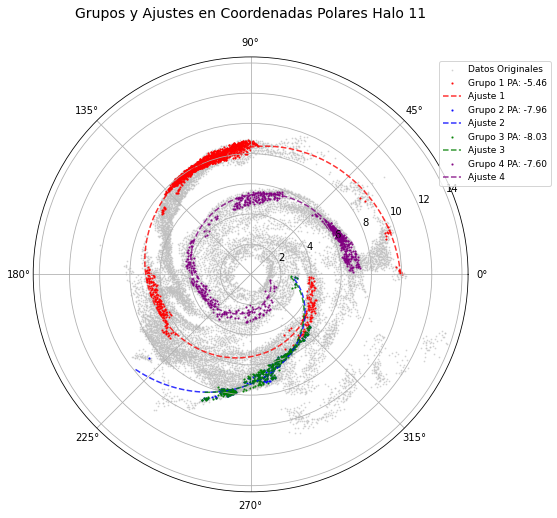

In [3]:
# Ejecutar iteraciones
id_halo = "11"
quartile_threshold_IT1, quartile_threshold_IT2 = 0.85, 0.80
radius_tolerance_IT1, radius_tolerance_IT2 = 0.56, 0.65
point_distance_tolerance_IT1, point_distance_tolerance_IT2 = 0.58, 0.69
flexible_pa_range = (4.0, 30.0)

# Primera iteración
clusters_polar_IT1, df = process_spiral_arms(id_halo, quartile_threshold_IT1, radius_tolerance_IT1, point_distance_tolerance_IT1, flexible_pa_range)
theta_min, theta_max = df['theta'].min(), df['theta'].max()
valid_groups_IT1 = count_intersections(clusters_polar_IT1, theta_min, theta_max)

# Segunda iteración
clusters_polar_IT2, _ = process_spiral_arms(id_halo, quartile_threshold_IT2, radius_tolerance_IT2, point_distance_tolerance_IT2, flexible_pa_range)
valid_groups_IT2 = count_intersections(clusters_polar_IT2, theta_min, theta_max)

# Combinar los resultados
valid_groups_combined = valid_groups_IT1 + valid_groups_IT2
print(f"Total de grupos combinados: {len(valid_groups_combined)}")

# Graficar resultados
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
theta_all = np.radians(df['theta'])
ax.scatter(theta_all, df['r'], s=0.6, alpha=0.6, color='silver', label='Datos Originales')
colors = ['red', 'blue', 'green', 'purple', 'orange']
for idx, group in enumerate(valid_groups_combined):
    points = group['points']
    theta_group = np.radians(points['theta'])
    r_group = points['r']
    pa = group['pa']
    ax.scatter(theta_group, r_group, s=1.5, alpha=0.8, label=f'Grupo {idx+1} PA: {pa:.2f}', color=colors[idx % len(colors)])
    theta_line = np.linspace(points['theta'].min(), points['theta'].max(), 1000)
    r_line = group['slope'] * theta_line + group['intercept']
    ax.plot(np.radians(theta_line), r_line, linestyle='--', linewidth=1.5, alpha=0.8, label=f'Ajuste {idx+1}', color=colors[idx % len(colors)])
ax.set_title(f"Grupos y Ajustes en Coordenadas Polares Halo {id_halo}", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9)
plt.show()


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 

Total de grupos combinados: 10


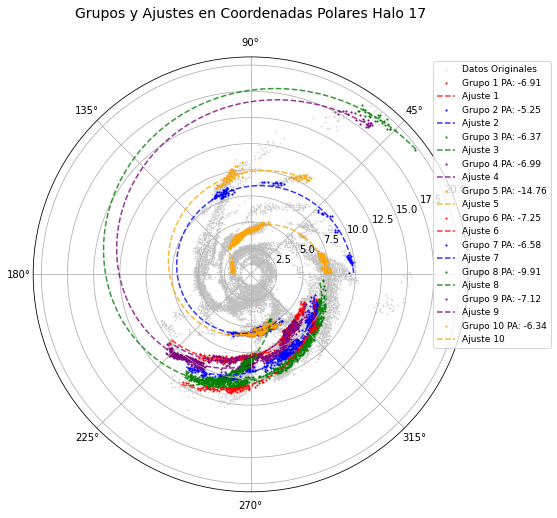

In [4]:
# Ejecutar iteraciones
id_halo = "17"
quartile_threshold_IT1, quartile_threshold_IT2 = 0.55, 0.80
radius_tolerance_IT1, radius_tolerance_IT2 = 0.40, 0.55
point_distance_tolerance_IT1, point_distance_tolerance_IT2 = 0.55, 0.59
flexible_pa_range = (4.0, 30.0)

# Primera iteración
clusters_polar_IT1, df = process_spiral_arms(id_halo, quartile_threshold_IT1, radius_tolerance_IT1, point_distance_tolerance_IT1, flexible_pa_range)
theta_min, theta_max = df['theta'].min(), df['theta'].max()
valid_groups_IT1 = count_intersections(clusters_polar_IT1, theta_min, theta_max)

# Segunda iteración
clusters_polar_IT2, _ = process_spiral_arms(id_halo, quartile_threshold_IT2, radius_tolerance_IT2, point_distance_tolerance_IT2, flexible_pa_range)
valid_groups_IT2 = count_intersections(clusters_polar_IT2, theta_min, theta_max)

# Combinar los resultados
valid_groups_combined = valid_groups_IT1 + valid_groups_IT2
print(f"Total de grupos combinados: {len(valid_groups_combined)}")

# Graficar resultados
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
theta_all = np.radians(df['theta'])
ax.scatter(theta_all, df['r'], s=0.6, alpha=0.6, color='silver', label='Datos Originales')
colors = ['red', 'blue', 'green', 'purple', 'orange']
for idx, group in enumerate(valid_groups_combined):
    points = group['points']
    theta_group = np.radians(points['theta'])
    r_group = points['r']
    pa = group['pa']
    ax.scatter(theta_group, r_group, s=1.5, alpha=0.8, label=f'Grupo {idx+1} PA: {pa:.2f}', color=colors[idx % len(colors)])
    theta_line = np.linspace(points['theta'].min(), points['theta'].max(), 1000)
    r_line = group['slope'] * theta_line + group['intercept']
    ax.plot(np.radians(theta_line), r_line, linestyle='--', linewidth=1.5, alpha=0.8, label=f'Ajuste {idx+1}', color=colors[idx % len(colors)])
ax.set_title(f"Grupos y Ajustes en Coordenadas Polares Halo {id_halo}", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9)
plt.show()

Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.4, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.4, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.4, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.5, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.5, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.5, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.55, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.55, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.39, radius_tolerance=0.55, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.4, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.4, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.4, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.5, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.5, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.5, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.55, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.55, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.55, radius_tolerance=0.55, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.4, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.4, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.4, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.5, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.5, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.5, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.55, point_distance_tolerance=0.55


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.55, point_distance_tolerance=0.58


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ejecutando con: quartile_threshold=0.81, radius_tolerance=0.55, point_distance_tolerance=0.6


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Total de grupos combinados en todas las iteraciones: 65


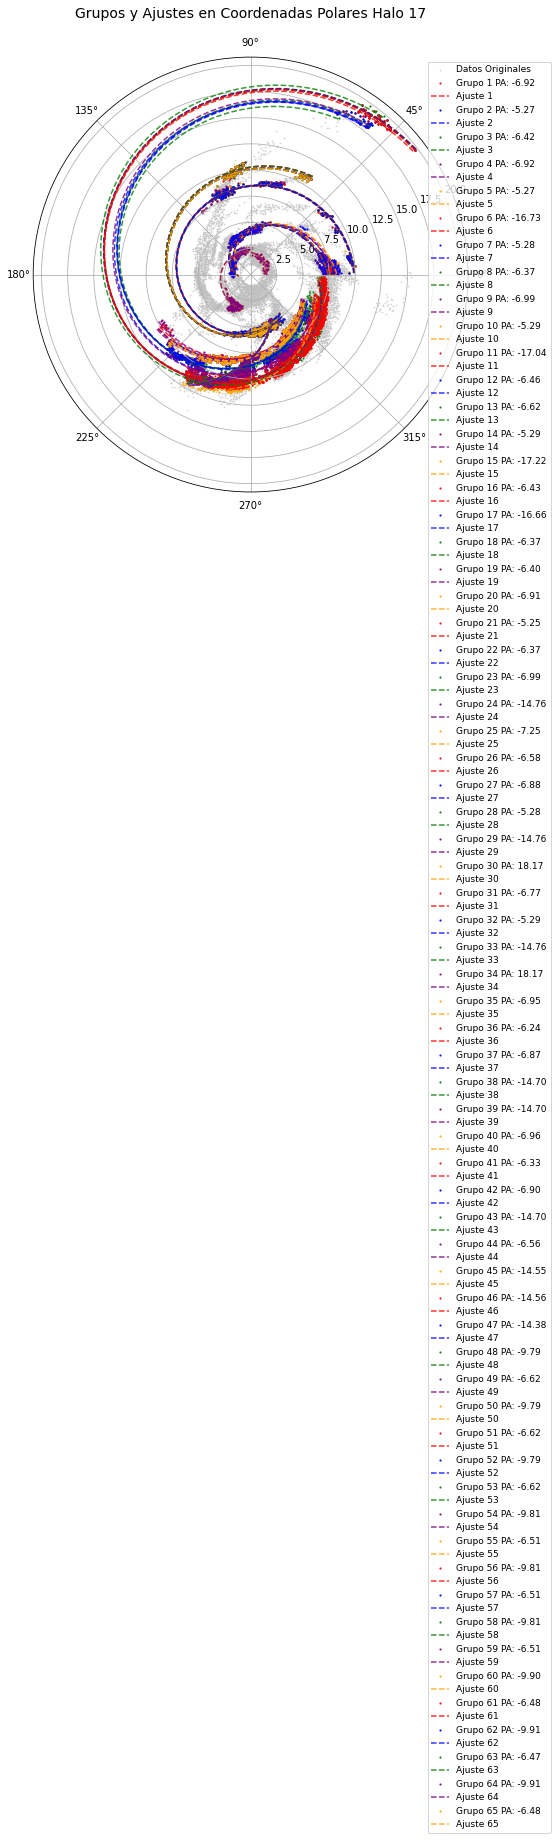

In [5]:
# Ejecutar iteraciones en un rango de valores
id_halo = "17"
quartile_threshold_values = [0.39, 0.55, 0.81]
radius_tolerance_values = [0.40, 0.50, 0.55]
point_distance_tolerance_values = [0.55, 0.58, 0.60]
flexible_pa_range = (4.0, 30.0)

best_groups = []

for quartile_threshold in quartile_threshold_values:
    for radius_tolerance in radius_tolerance_values:
        for point_distance_tolerance in point_distance_tolerance_values:
            print(f"Ejecutando con: quartile_threshold={quartile_threshold}, radius_tolerance={radius_tolerance}, point_distance_tolerance={point_distance_tolerance}")
            clusters_polar, df = process_spiral_arms(id_halo, quartile_threshold, radius_tolerance, point_distance_tolerance, flexible_pa_range)
            theta_min, theta_max = df['theta'].min(), df['theta'].max()
            valid_groups = count_intersections(clusters_polar, theta_min, theta_max)
            best_groups.extend(valid_groups)

print(f"Total de grupos combinados en todas las iteraciones: {len(best_groups)}")

# Graficar resultados
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
theta_all = np.radians(df['theta'])
ax.scatter(theta_all, df['r'], s=0.6, alpha=0.6, color='silver', label='Datos Originales')
colors = ['red', 'blue', 'green', 'purple', 'orange']
for idx, group in enumerate(best_groups):
    points = group['points']
    theta_group = np.radians(points['theta'])
    r_group = points['r']
    pa = group['pa']
    ax.scatter(theta_group, r_group, s=1.5, alpha=0.8, label=f'Grupo {idx+1} PA: {pa:.2f}', color=colors[idx % len(colors)])
    theta_line = np.linspace(points['theta'].min(), points['theta'].max(), 1000)
    r_line = group['slope'] * theta_line + group['intercept']
    ax.plot(np.radians(theta_line), r_line, linestyle='--', linewidth=1.5, alpha=0.8, label=f'Ajuste {idx+1}', color=colors[idx % len(colors)])
ax.set_title(f"Grupos y Ajustes en Coordenadas Polares Halo {id_halo}", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9)
plt.show()
